# TP6 - Clasificador de imágenes con red convolucional

Guarda una copia de este cuaderno en tu Google Drive para poder editarla y ejecutarla.

El propio cuaderno será tu informe del trabajo. Puedes añadir tantas secciones de código y de texto como consideres necesario para resolver todos los ejercicios propuestos y analizar los resultados obtenidos. Una vez hayas terminado, descarga el notebook en formato ipynb y súbelo a Moodle en la tarea habilitada para el TP6 con el nombre NIP_TP6_CNN.ipynb

Es **obligatorio** que se **guarden los resultados de la evaluación** de cada celda de código (para no tener que volver a ejecutarlas). Por defecto los notebooks estan configurados así (Edit→Notebook Settings → NUNCA actives: Omit code cell output when saving this notebook)

El Notebook incluye código de ejemplo para definir y entrenar una red convolucional con el dataset MNIST. Recuerda que **esta parte del trabajo se debe realizar con el dataset CIFAR 10**.

Imports necesarios para ejecutar el trabajo

In [ ]:
import time
import numpy as np
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return

    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)

    ## Loss
    fig, axs = plt.subplots(1, 2,  figsize=(12, 6))
    for l in loss_list:
        axs[0].plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        axs[0].plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))

    axs[0].set(title='Loss', xlabel='Epochs', ylabel='Loss')
    axs[0].grid()
    axs[0].legend()

    ## Accuracy
    for l in acc_list:
        axs[1].plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:
        axs[1].plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    axs[1].set(title='Accuracy', xlabel='Epochs', ylabel='Accuracy')
    axs[1].grid()
    axs[1].legend()
    plt.show()

Carga del dataset MNIST

Importante observar como la organización de los datos es diferente que en el caso del perceptrón para poder aplicar bien las convoluciones

In [ ]:
# LOAD MNIST
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test  = tf.keras.utils.to_categorical(y_test,  num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
# Definicion de la red convolucional
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

## Preguntas a responder de la celda anterior:

### 1.    Incluye un dibujo de la arquitectura de la red programada en la celda anterior.


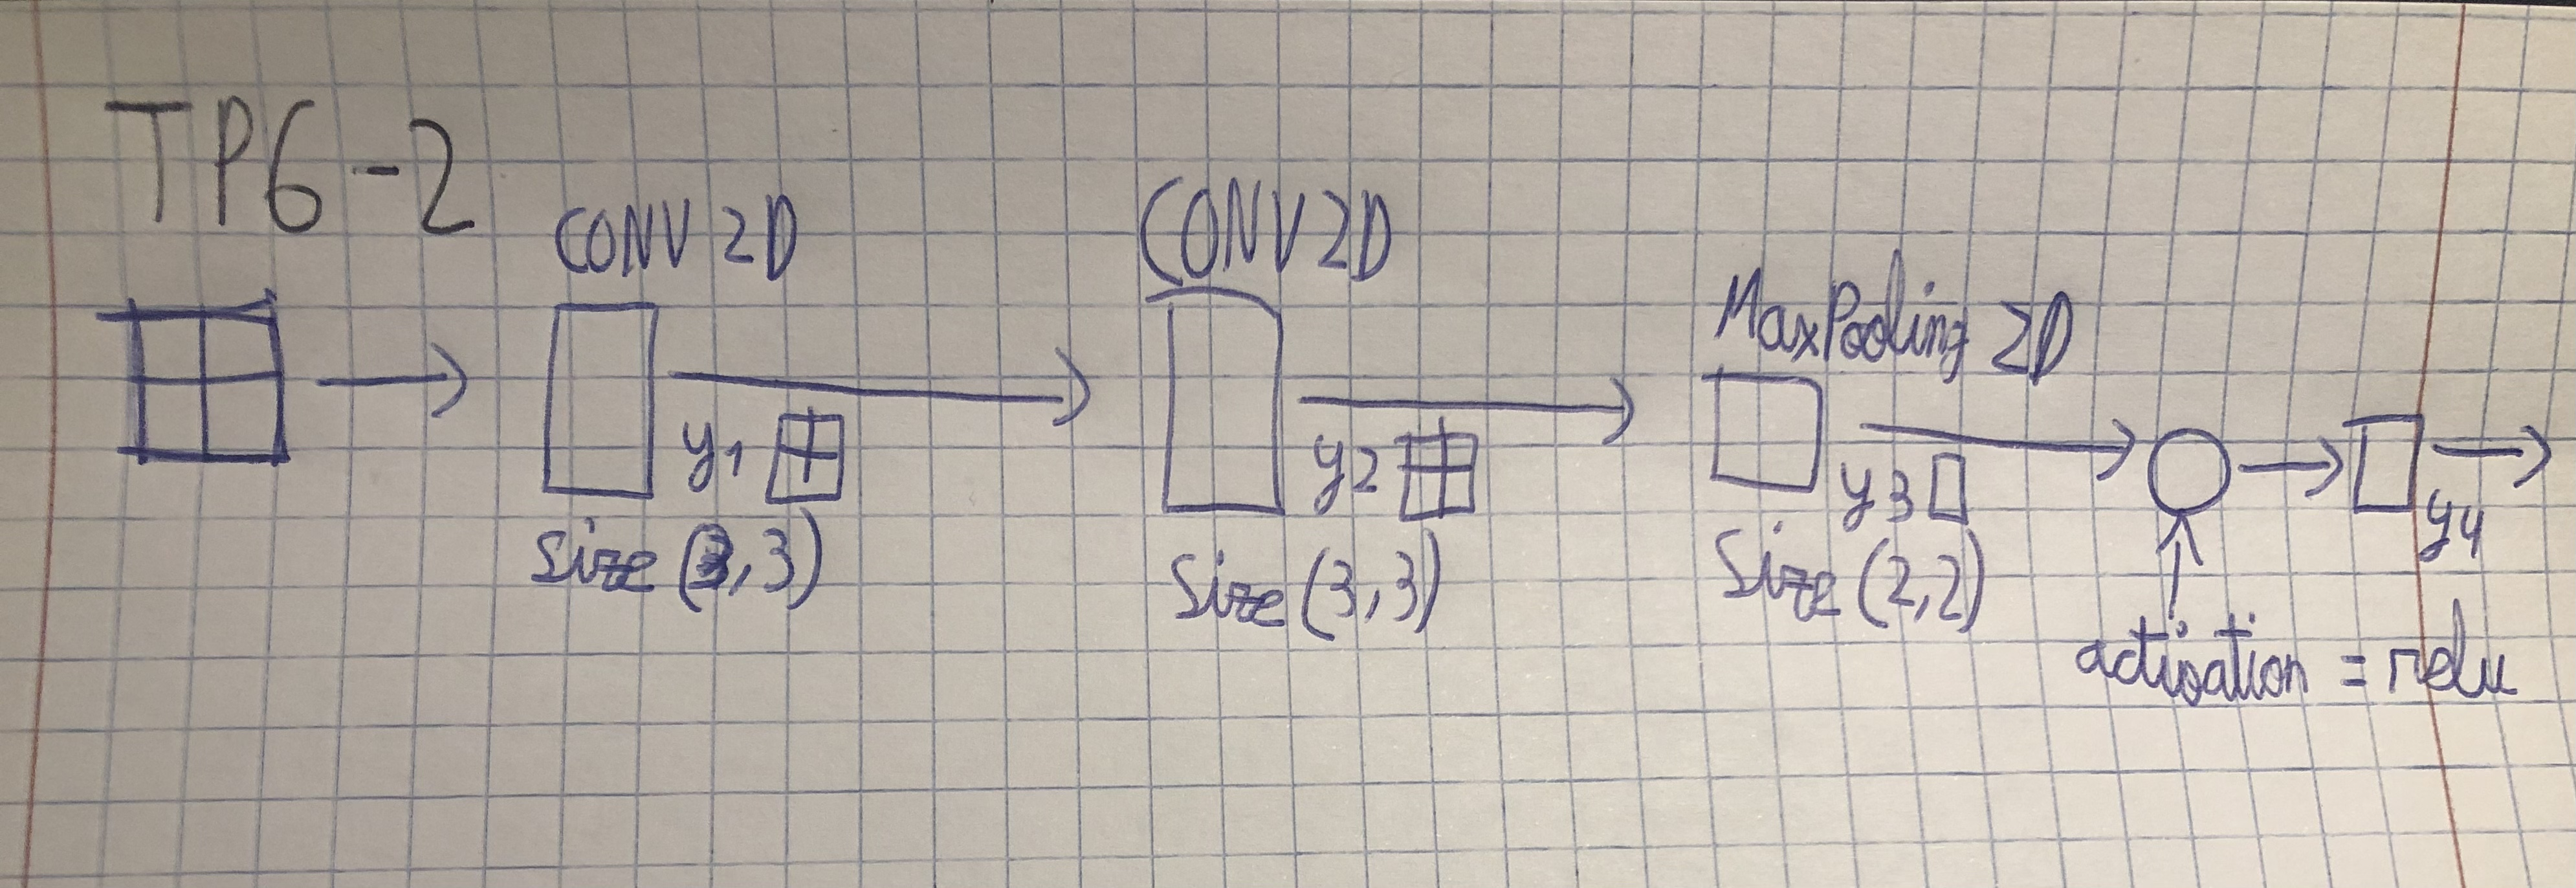

### 2.    Explica brevemente qué hace cada capa de la red.

La capa Conv2D se encarga de procesar los datos de la entrada en 2 dimensiones como si fueran una imagen. Es decir, aplica filtros para extraer la información importante y con eso genera una matriz de datos.

La MaxPooling2D simplemente redimensiona la matriz de la capa anterior mediante una función de agregación.

Por último Flatten hace una unión mediante una conversión entre estas dos capas y las capas Dense ya que el tipo de entrada es incorrecto, pues Dense necesita vectores y le estamos pasando matrices.

## Entrenamiento

Epoch 1/12
469/469 [==============================] - 8s 9ms/step - loss: 0.2370 - accuracy: 0.9267
Epoch 2/12
469/469 [==============================] - 4s 9ms/step - loss: 0.0851 - accuracy: 0.9744
Epoch 3/12
469/469 [==============================] - 4s 9ms/step - loss: 0.0631 - accuracy: 0.9816
Epoch 4/12
469/469 [==============================] - 4s 9ms/step - loss: 0.0509 - accuracy: 0.9843
Epoch 5/12
469/469 [==============================] - 4s 8ms/step - loss: 0.0425 - accuracy: 0.9870
Epoch 6/12
469/469 [==============================] - 4s 9ms/step - loss: 0.0388 - accuracy: 0.9879
Epoch 7/12
469/469 [==============================] - 4s 8ms/step - loss: 0.0320 - accuracy: 0.9894
Epoch 8/12
469/469 [==============================] - 4s 8ms/step - loss: 0.0323 - accuracy: 0.9897
Epoch 9/12
469/469 [==============================] - 4s 9ms/step - loss: 0.0276 - accuracy: 0.9909
Epoch 10/12
469/469 [==============================] - 4s 8ms/step - loss: 0.0255 - accuracy: 0.9919

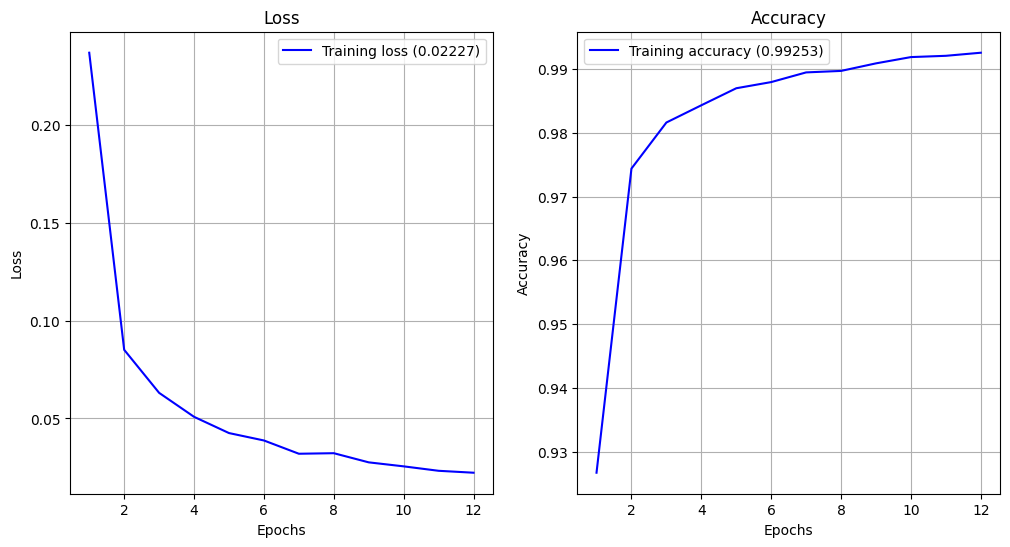

In [ ]:
# Ajuste de los parámetros de la red
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_history(history)

## Preguntas a responder de la celda anterior

¿Qué diferencias observas en el entrenamiento y en los resultados en comparación con las redes diseñadas en el otro Notebook?

La cantidad de epoch han pasado de 20 a 12, además la cantidad de datos usados en comparación es de menos del 10% en x_train.

Por el resto los resultados son muy similares en este caso con un 99.29% y en la otra da 98.02%

##TAREAS A REALIZAR

Nota aclaratoria:

Ha habido varias veces que he tenido que ejecutar todo por algún error raro, por lo que puede que haya algún porcentaje que no coincida exactamente.

El notebook que entregues deberá incluir:

1.   Modifica la carga de datos, y la configuración inicial de la red si lo ves necesario, para que cargue/utilice el dataset CIFAR10 en lugar de MNIST. Puedes pasar a blanco y negro las imágenes, o hacer que la red trabaje con imagenes en color (n x m x 3), y siempre, normalizar los valores (atributos con valores entre 0 y 1).
2.   Entrena un perceptrón multi-capa y evalúa los resultados que obtiene para CIFAR10. Compara estos resultados con los obtenidos en el dataset anterior (MNIST)
3.   Entrena una red convolucional y evalúa los resultados que obtiene con CIFAR10. Compara estos resultados con los obtenidos para el perceptrón.
4.   Opcional: Repite el último paso, entrenar la red convolucional, utilizando el dataset CIFAR 100, con 100 clases diferentes. En este caso, recuerda asegurarte que el Colab está utilizando una configuración con GPU.

Tarea 1

In [ ]:
# LOAD CIFAR10
batch_size = 128
num_classes = 10
epochs = 20

# input image dimensions
img_rows, img_cols = 32, 32

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test  = tf.keras.utils.to_categorical(y_test,  num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


Tarea 2

In [ ]:
#Creación de una función earlystop para el perceptron
earlystop=EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
# Perceptron con dos capas
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(256, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               786688    
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 10)                2570      
                                                                 
Total params: 855050 (3.26 MB)
Trainable params: 855050 (3.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/20
352/352 [==============================] - 3s 5ms/step - loss: 2.0255 - accuracy: 0.2572 - val_loss: 1.8841 - val_accuracy: 0.3262
Epoch 2/20
352/352 [==============================] - 2s 5ms/step - loss: 1.8297 - accuracy: 0.3433 - val_loss: 1.8008 - val_accuracy: 0.3558
Epoch 3/20
352/352 [==============================] - 2s 5ms/step - loss: 1.7436 - accuracy: 0.3756 - val_loss: 1.7582 - val_accuracy: 0.3528
Epoch 4/20
352/352 [==============================] - 2s 6ms/step - loss: 1.6804 - accuracy: 0.3984 - val_loss: 1.7672 - val_accuracy: 0.3634
Epoch 5/20
352/352 [==============================] - 2s 4ms/step - loss: 1.6369 - accuracy: 0.4163 - val_loss: 1.5890 - val_accuracy: 0.4380
Epoch 6/20
352/352 [==============================] - 2s 4ms/step - loss: 1.5980 - accuracy: 0.4320 - val_loss: 1.6082 - val_accuracy: 0.4244
Epoch 7/20
352/352 [==============================] - 2s 4ms/step - loss: 1.5664 - accuracy: 0.4414 - val_loss: 1.6939 - val_accuracy: 0.3960
Epoch 

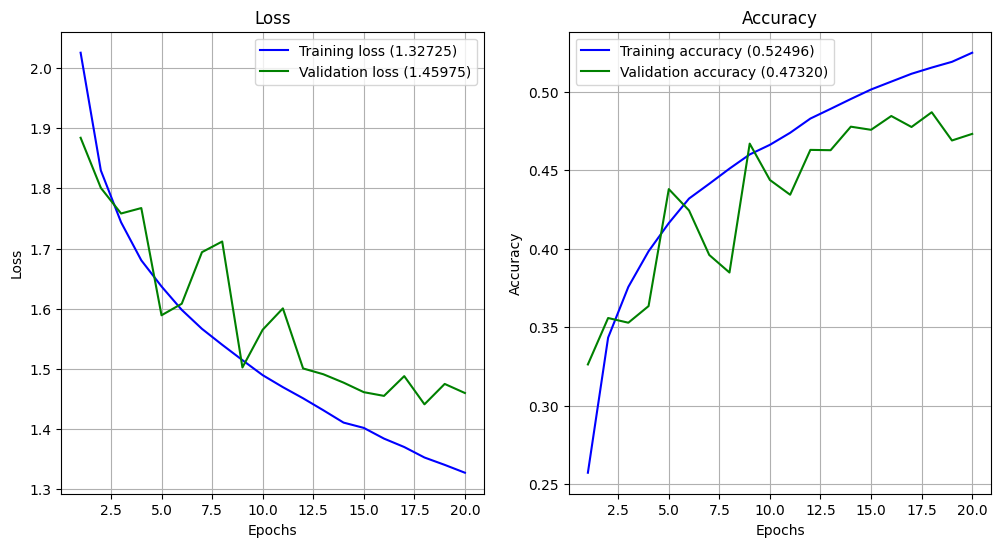

In [ ]:
# Ajuste de los parámetros de la red
t0 = time.perf_counter()
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split = 0.1,
          callbacks = [earlystop],
          verbose=True)
train_time = time.perf_counter() - t0
print('%s %.3f%s' % ('Training time: ', train_time, 's'))
plot_history(history)

In [ ]:
# Evaluar la red
train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)
print('%s %2.2f%s' % ('Accuracy train: ', 100*train_score[1], '%'))
print('%s %2.2f%s' % ('Accuracy test: ', 100*test_score[1], '%'))

Accuracy train:  51.28%
Accuracy test:  47.76%


El resultado obtenido de la anterior es de 98.02% mientras que el nuevo es de 49.43%, con lo que los resultados son peores, lo cual es normal ya que la resolución es mayor y además las imágenes son muy distintas entre si.

Tarea 3

In [ ]:
#Ajustes de los parámetros para nueva tarea
batch_size = 128
num_classes = 10
epochs = 12

In [ ]:
# Definicion de la red convolucional
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 128)       73856     
                                                      

Epoch 1/12
391/391 [==============================] - 9s 16ms/step - loss: 1.7876 - accuracy: 0.3288
Epoch 2/12
391/391 [==============================] - 5s 14ms/step - loss: 1.3401 - accuracy: 0.5153
Epoch 3/12
391/391 [==============================] - 6s 15ms/step - loss: 1.1441 - accuracy: 0.5950
Epoch 4/12
391/391 [==============================] - 5s 14ms/step - loss: 1.0167 - accuracy: 0.6437
Epoch 5/12
391/391 [==============================] - 6s 15ms/step - loss: 0.9306 - accuracy: 0.6772
Epoch 6/12
391/391 [==============================] - 6s 14ms/step - loss: 0.8673 - accuracy: 0.7003
Epoch 7/12
391/391 [==============================] - 6s 15ms/step - loss: 0.8129 - accuracy: 0.7209
Epoch 8/12
391/391 [==============================] - 6s 14ms/step - loss: 0.7712 - accuracy: 0.7314
Epoch 9/12
391/391 [==============================] - 6s 14ms/step - loss: 0.7318 - accuracy: 0.7489
Epoch 10/12
391/391 [==============================] - 6s 15ms/step - loss: 0.7064 - accura

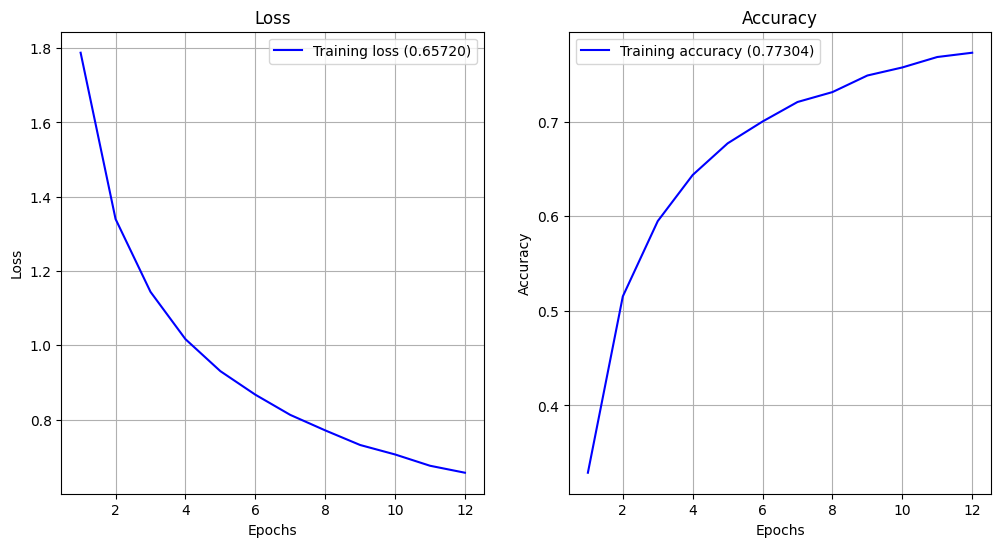

In [ ]:
# Ajuste de los parámetros de la red
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_history(history)

Dado que este tipo de redes es mucho más eficiente para procesar imágenes se obtienen mejores resultados tal y como vemos que recibimos un 77% frente al 49.43% anterior.

Tarea 4

Resultados obtenidos en las distintas pruebas realizadas.

Conv2D 32-3x3-relu + Conv2D 64-3x3-relu + MaxPooling2D 2x2 + Dropout 0.25 + Flatten +
Dense 128-relu + Dropout 0.5 + Dense 10-softmax + optimizador Adam  

Loss = 0.0203, Accuracy = 0.9899


---


Conv2D 32-3x3-relu + Conv2D 64-3x3-relu + MaxPooling2D 2x2 + Dropout 0.25 + Flatten +
Dense 128-relu + Dropout 0.5 + Dense 10-sigmoid + optimizador Adam

Loss = 0.0211, Accuracy = 0.9912


---


Conv2D 32-3x3-relu + Conv2D 64-3x3-relu + MaxPooling2D 2x2 + Dropout 0.25 + Flatten +
Dense 500-relu + Dropout 0.75 + Dense 10-softmax + optimizador Adam

Loss = 0.0286, Accuracy = 0.9934


---


Conv2D 32-3x3-relu + Conv2D 64-3x3-relu + MaxPooling2D 2x2 + Dropout 0.25 + Flatten +
Dense 10-relu + Dropout 0.5 + Dense 10-softmax + optimizador Adam

Loss = 0.7394, Accuracy = 0.6673